Data loaded successfully.

Initial Data:
   Unnamed: 0    Worker1    Worker2    Worker3    Worker4    Worker5
0  2020-01-01  54.706560  45.344267  91.494013  59.856383  50.172134
1  2020-01-02  55.020775  45.783240  90.958020  60.097179  50.445878
2  2020-01-03  55.334606  46.221771  91.100623  59.768485  50.719282
3  2020-01-04  55.647661  46.659459  91.383928  59.883758  50.991996
4  2020-01-05  55.959489  47.095844  92.023932  60.378699  51.263612
Summary Statistics:
           Worker1      Worker2      Worker3      Worker4      Worker5
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000
mean     81.769017    67.517395    87.616528    54.014533    77.517277
std      16.353626    17.232467     5.599575     6.986980    16.073298
min      52.143771    32.931608    76.292762    41.249365    49.771203
25%      68.033955    55.738936    83.305288    47.510612    63.823789
50%      81.988528    67.387501    87.081399    53.603258    77.223095
75%      95.490317    79.038

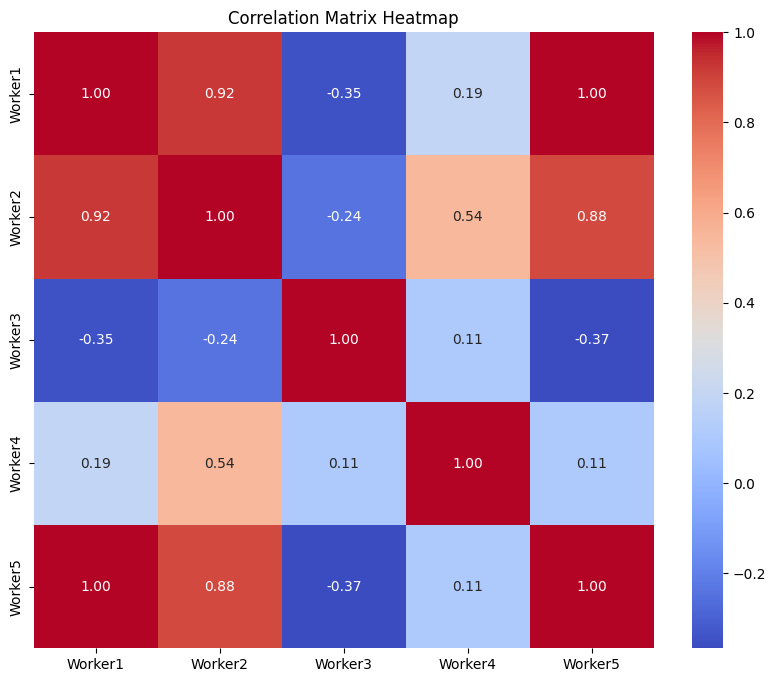

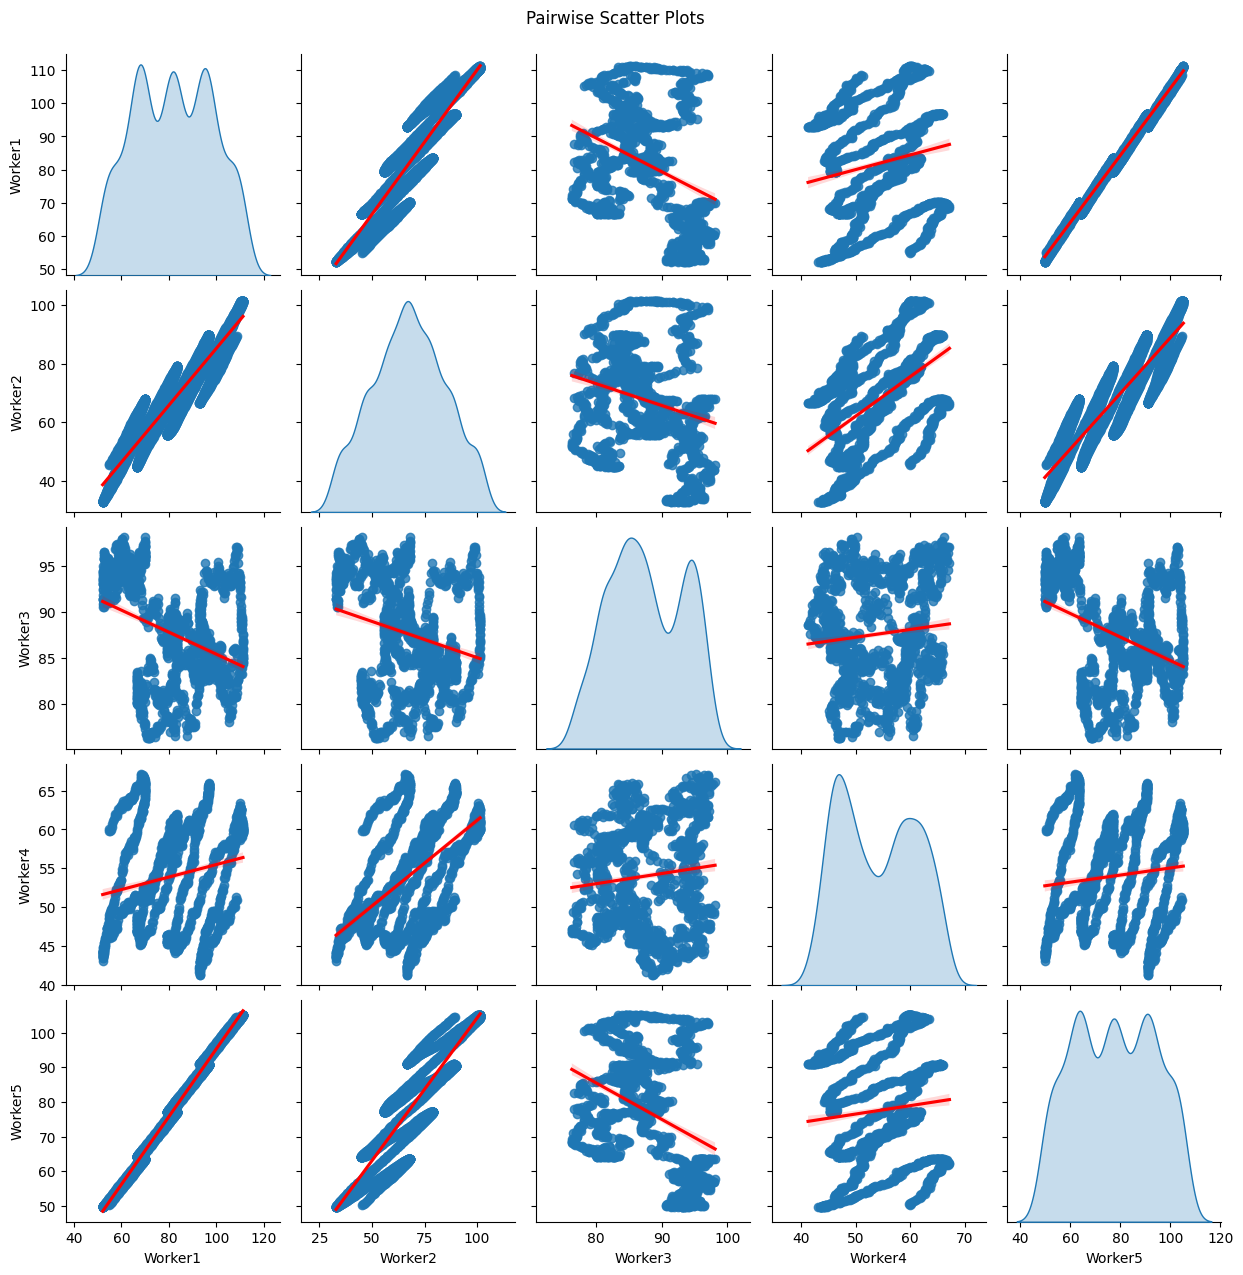

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

# Load the dataset
def load_data(file_path):
    """Loads the dataset from a CSV file."""
    try:
        data = pd.read_csv(file_path)
        print("Data loaded successfully.")
        return data
    except FileNotFoundError:
        print("File not found. Please check the file path.")
        return None

# Summary Statistics
def summary_statistics(data):
    """Generates summary statistics for each worker."""
    print("Summary Statistics:")
    print(data.describe())

# Correlation Analysis
def correlation_analysis(data):
    """Performs correlation analysis and visualizes the results."""
    print("Correlation Matrix:")
    correlation_matrix = data.corr()  # Pearson Correlation Matrix
    print(correlation_matrix)

    # Heatmap of the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Correlation Matrix Heatmap")
    plt.show()

    # Pairwise scatter plots with regression lines
    sns.pairplot(data, kind="reg", diag_kind="kde", plot_kws={'line_kws':{'color':'red'}})
    plt.suptitle("Pairwise Scatter Plots", y=1.02)
    plt.show()

# Pairwise Correlation Tests
def pairwise_correlation_tests(data):
    """Performs pairwise correlation tests for each worker pair."""
    # Ensure all data is numeric
    numeric_data = data.apply(pd.to_numeric, errors='coerce')
    
    # Drop columns with non-numeric or NaN values
    numeric_data = numeric_data.dropna(axis=1, how='any')
    
    if numeric_data.shape[1] < 2:
        print("Not enough numeric columns for correlation analysis.")
        return pd.DataFrame()
    
    workers = numeric_data.columns
    results = []
    for i in range(len(workers)):
        for j in range(i + 1, len(workers)):
            w1, w2 = workers[i], workers[j]
            try:
                pearson_corr, pearson_p = pearsonr(numeric_data[w1], numeric_data[w2])
                spearman_corr, spearman_p = spearmanr(numeric_data[w1], numeric_data[w2])
                results.append({
                    "Worker Pair": f"{w1} & {w2}",
                    "Pearson Correlation": pearson_corr,
                    "Pearson P-value": pearson_p,
                    "Spearman Correlation": spearman_corr,
                    "Spearman P-value": spearman_p
                })
            except ValueError as e:
                print(f"Error computing correlation for {w1} and {w2}: {e}")
    
    results_df = pd.DataFrame(results)
    print("Pairwise Correlation Tests:")
    print(results_df)
    return results_df


# Visualization of Time-Series Patterns
def time_series_visualization(data):
    """Visualizes the time series productivity data for each worker."""
    plt.figure(figsize=(14, 8))
    for worker in data.columns:
        plt.plot(data.index, data[worker], label=worker)
    plt.title("Time Series of Worker Productivity")
    plt.xlabel("Days")
    plt.ylabel("Products per Day")
    plt.legend()
    plt.grid(True)
    plt.show()

# Main Function
def main():
    file_path = "synthetic_worker_productivity.csv"  # Replace with your CSV file path
    data = load_data(file_path)

    if data is not None:
        print("\nInitial Data:")
        print(data.head())

        # Summary Statistics
        summary_statistics(data)

        # Correlation Analysis
        correlation_analysis(data)

        # # Pairwise Correlation Tests
        # pairwise_results = pairwise_correlation_tests(data)

        # # Time-Series Visualization
        # time_series_visualization(data)

if __name__ == "__main__":
    main()


Data loaded successfully.
Model fitted with lag order 5
Mean Absolute Error (MAE): 2.0709654331315615
Root Mean Squared Error (RMSE): 4.02986042390914


D:\VENV_PYTHON\py3_8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


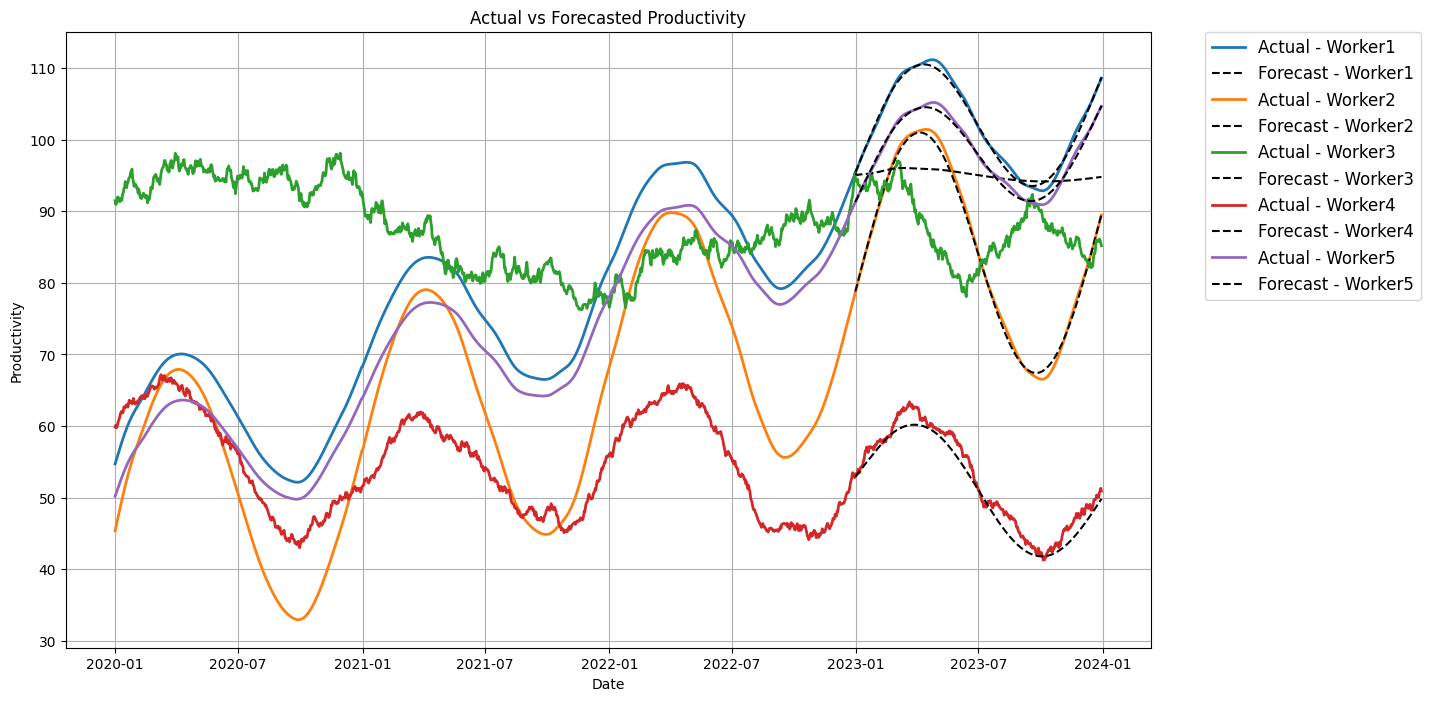

In [15]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the dataset
def load_data(file_path):
    """Loads the dataset from a CSV file."""
    try:
        data = pd.read_csv(file_path, index_col=0, parse_dates=True)
        print("Data loaded successfully.")
        return data
    except FileNotFoundError:
        print("File not found. Please check the file path.")
        return None

# Preprocess the data
def preprocess_data(data):
    """Preprocesses the data for VAR modeling."""
    # Ensure all columns are numeric
    data = data.apply(pd.to_numeric, errors='coerce').dropna()
    return data

# Fit the VAR model
def fit_var_model(data, lag_order):
    """Fits a VAR model to the data."""
    model = VAR(data)
    results = model.fit(lag_order)
    print(f"Model fitted with lag order {lag_order}")
    return results

# Forecast future values
def forecast_future(model, data, steps):
    """Forecasts future values using the fitted VAR model."""
    forecast = model.forecast(data.values[-model.k_ar:], steps=steps)
    forecast_index = pd.date_range(start=data.index[-1], periods=steps + 1, freq="D")[1:]
    forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=data.columns)
    return forecast_df

# Evaluate the model
def evaluate_model(actual, predicted):
    """Evaluates the model's predictions."""
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    return mae, rmse

# Visualize predictions
def visualize_predictions(data, forecast_df):
    """Visualizes the actual and forecasted data."""
    plt.figure(figsize=(14, 8))
    for column in data.columns:
        plt.plot(data.index, data[column], label=f"Actual - {column}", lw=2)
        plt.plot(forecast_df.index, forecast_df[column], linestyle="--", label=f"Forecast - {column}", lw=1.5, color='black')
    plt.title("Actual vs Forecasted Productivity")
    plt.xlabel("Date")
    plt.ylabel("Productivity")
    plt.legend(fontsize=12, loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.grid(True)
    plt.show()

# Main function
def main():
    file_path = "synthetic_worker_productivity.csv"  # Replace with your CSV file path
    data = load_data(file_path)

    if data is not None:
        # Preprocess the data
        data = preprocess_data(data)

        # Split the data into training and testing sets
        train_size = int(len(data) * 0.75)
        train_data = data.iloc[:train_size]
        test_data = data.iloc[train_size:]

        # Fit the VAR model
        lag_order = 5  # Specify the lag order (can be optimized)
        model_results = fit_var_model(train_data, lag_order)

        # Forecast future values
        forecast_steps = len(test_data)
        forecast_df = forecast_future(model_results, train_data, forecast_steps)

        # Evaluate the model
        evaluate_model(test_data.values, forecast_df.values)

        # Visualize the predictions
        visualize_predictions(data, forecast_df)

if __name__ == "__main__":
    main()
